# Housing Sale Price Prediction : Advanced Regression Assignment

## Steps
1. Reading and Understanding the data
2. Missing Value Treatment
3. Data Analysis and Visualization
4. Preparing the data for Modelling
    - Dummy Encoding
    - Train - Test split
    - Rescaling
5. Training the Model
6. Regularization and Tuning
7. Residual Analysis
8. Predictions and Evaluations on the test set

### Step 1: Reading and understanding the data

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the data
# Some of the columns have NA explicitely defined and it represents a particular category. So it shouldn't be treated as missing value. Hence reading them as string
cols_custom_read = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType',\
                    'GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']
custom_converters = {c : str for c in cols_custom_read}

housing_data = pd.read_csv('https://ml-course3-upgrad.s3.amazonaws.com/Assignment_+Advanced+Regression/train.csv', converters=custom_converters)
housing_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


In [3]:
# Understand the shape of the data
housing_data.shape

(1460, 81)

#### Observations
- Number of datapoints is 1460 which seems to be less
- There are 80 independent variables

In [4]:
# Understand the data types, presence of missing values
housing_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Step 2: Missing Value Treatment

In [5]:
#List the columns which has missing values
housing_data_na = housing_data.isna().sum()
housing_data_na[housing_data_na > 0]

LotFrontage    259
MasVnrType       8
MasVnrArea       8
Electrical       1
GarageYrBlt     81
dtype: int64

In [6]:
# Imputing LotFrontage with median value
median_lot_frontage = housing_data['LotFrontage'].describe()['50%']

#Imputing MasVnrType with Mode. Since Missing values for MasVnrArea is exactly where MasVnrType is missing, we have to consider the value for Mode while imputing MasVnrArea
mode_mas_vnr_type = housing_data['MasVnrType'].mode()[0]

#Since Mode for MasVnrType is none, corresponding MasVnrArea should be 0
imputed_mas_vnr_area = 0

# No need to impute GarageYrBlt, because GarageYrBlt is missing for GarageType No Garage, It makes sense to keep it as it is.

#Impute Electrical with mode
mode_electrical = housing_data['Electrical'].mode()[0]

#Impute the dataframe with the above values
housing_data.fillna(value={'LotFrontage':median_lot_frontage,'MasVnrType':mode_mas_vnr_type,'MasVnrArea':imputed_mas_vnr_area,'Electrical':mode_electrical},inplace=True)

In [7]:
#List the columns which has missing values after imputation
housing_data_na = housing_data.isna().sum()
housing_data_na[housing_data_na > 0]

GarageYrBlt    81
dtype: int64

In [8]:
#Drop unneccessary columns
cols_to_be_dropped = ['Id']
housing_data.drop(cols_to_be_dropped,axis=1,inplace=True)

#Drop any duplicates
housing_data.drop_duplicates()
# There are no duplicated rows

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,MnPrv,NA,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,4,2010,WD,Normal,142125


In [9]:
list(housing_data.columns)

['MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'Enc

### Step 3: Data Analysis and Visualization

In [10]:
categorical_vars = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2',\
                    'BldgType','HouseStyle','YearBuilt','YearRemodAdd','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType',\
                    'ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir', \
                    'Electrical','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','KitchenQual','TotRmsAbvGrd','Functional',\
                    'Fireplaces','FireplaceQu','GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageQual','GarageCond','PavedDrive','PoolQC','Fence',\
                    'MiscFeature','MoSold','YrSold','SaleType','SaleCondition']
continuous_vars = ['LotFrontage','LotArea','OverallQual','OverallCond','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',\
                    'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']

<Figure size 1440x720 with 0 Axes>

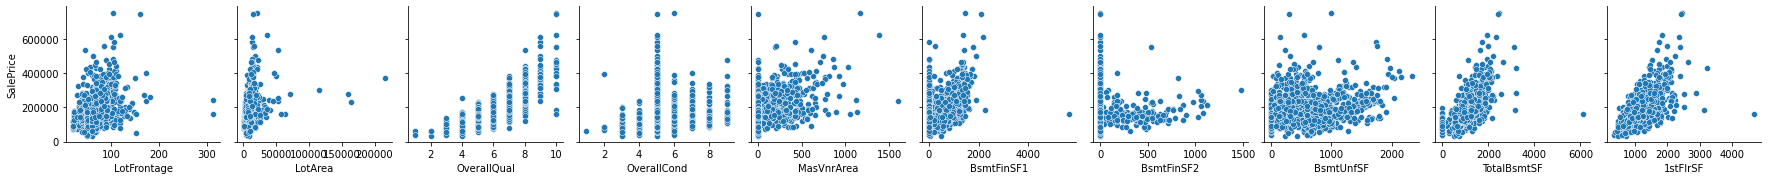

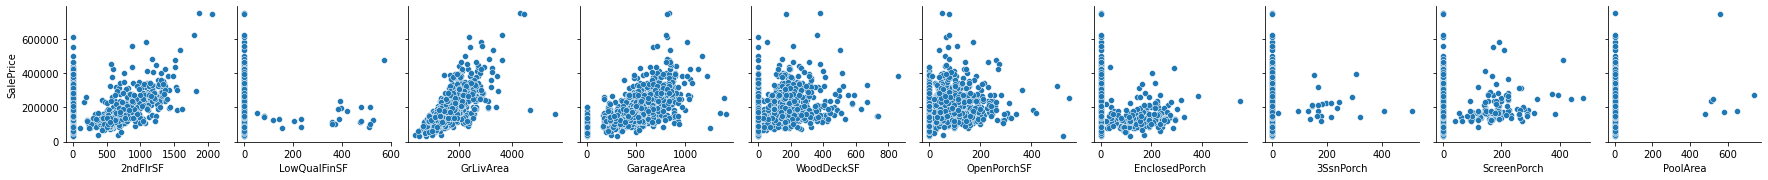

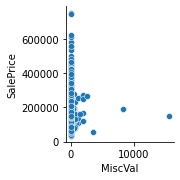

In [11]:
plt.figure(figsize=(20,10))
batch_size = 10
for i in range(0,len(continuous_vars),batch_size):
    sns.pairplot(data=housing_data,x_vars=continuous_vars[i:i+batch_size],y_vars='SalePrice')
plt.show()

#### Inferences
1. LotFrontage seems to have little influence on the SalePrice but seems to be linear influencer
2. LotArea seems to have not much influence on the target SalePrice
3. MasVnrArea, BsmtFinSF1 BsmtFinSF2, BsmtUnfSF seem to have little effect on the SalePrice. 
4. If we remove the value 0 for TotalBsmtSF,1stFlrSF, 2ndFlrSF, they seem to have to good influence on the target. 0 just represents that the particular category (basement, 1st floor or 2nd floor) is not there in the house
5. LowQualFinSF,WoodDeckSF,EnclosedPorch,3SsnPorch,ScreenPorch, PoolArea, MiscVal seems to have not much influence on the target, there are lot of zeros for these vars in the dataset which is also widely spread across different Sale Prices
6. GrLivArea and GarageArea seems to have a good linear influence on the SalePrice


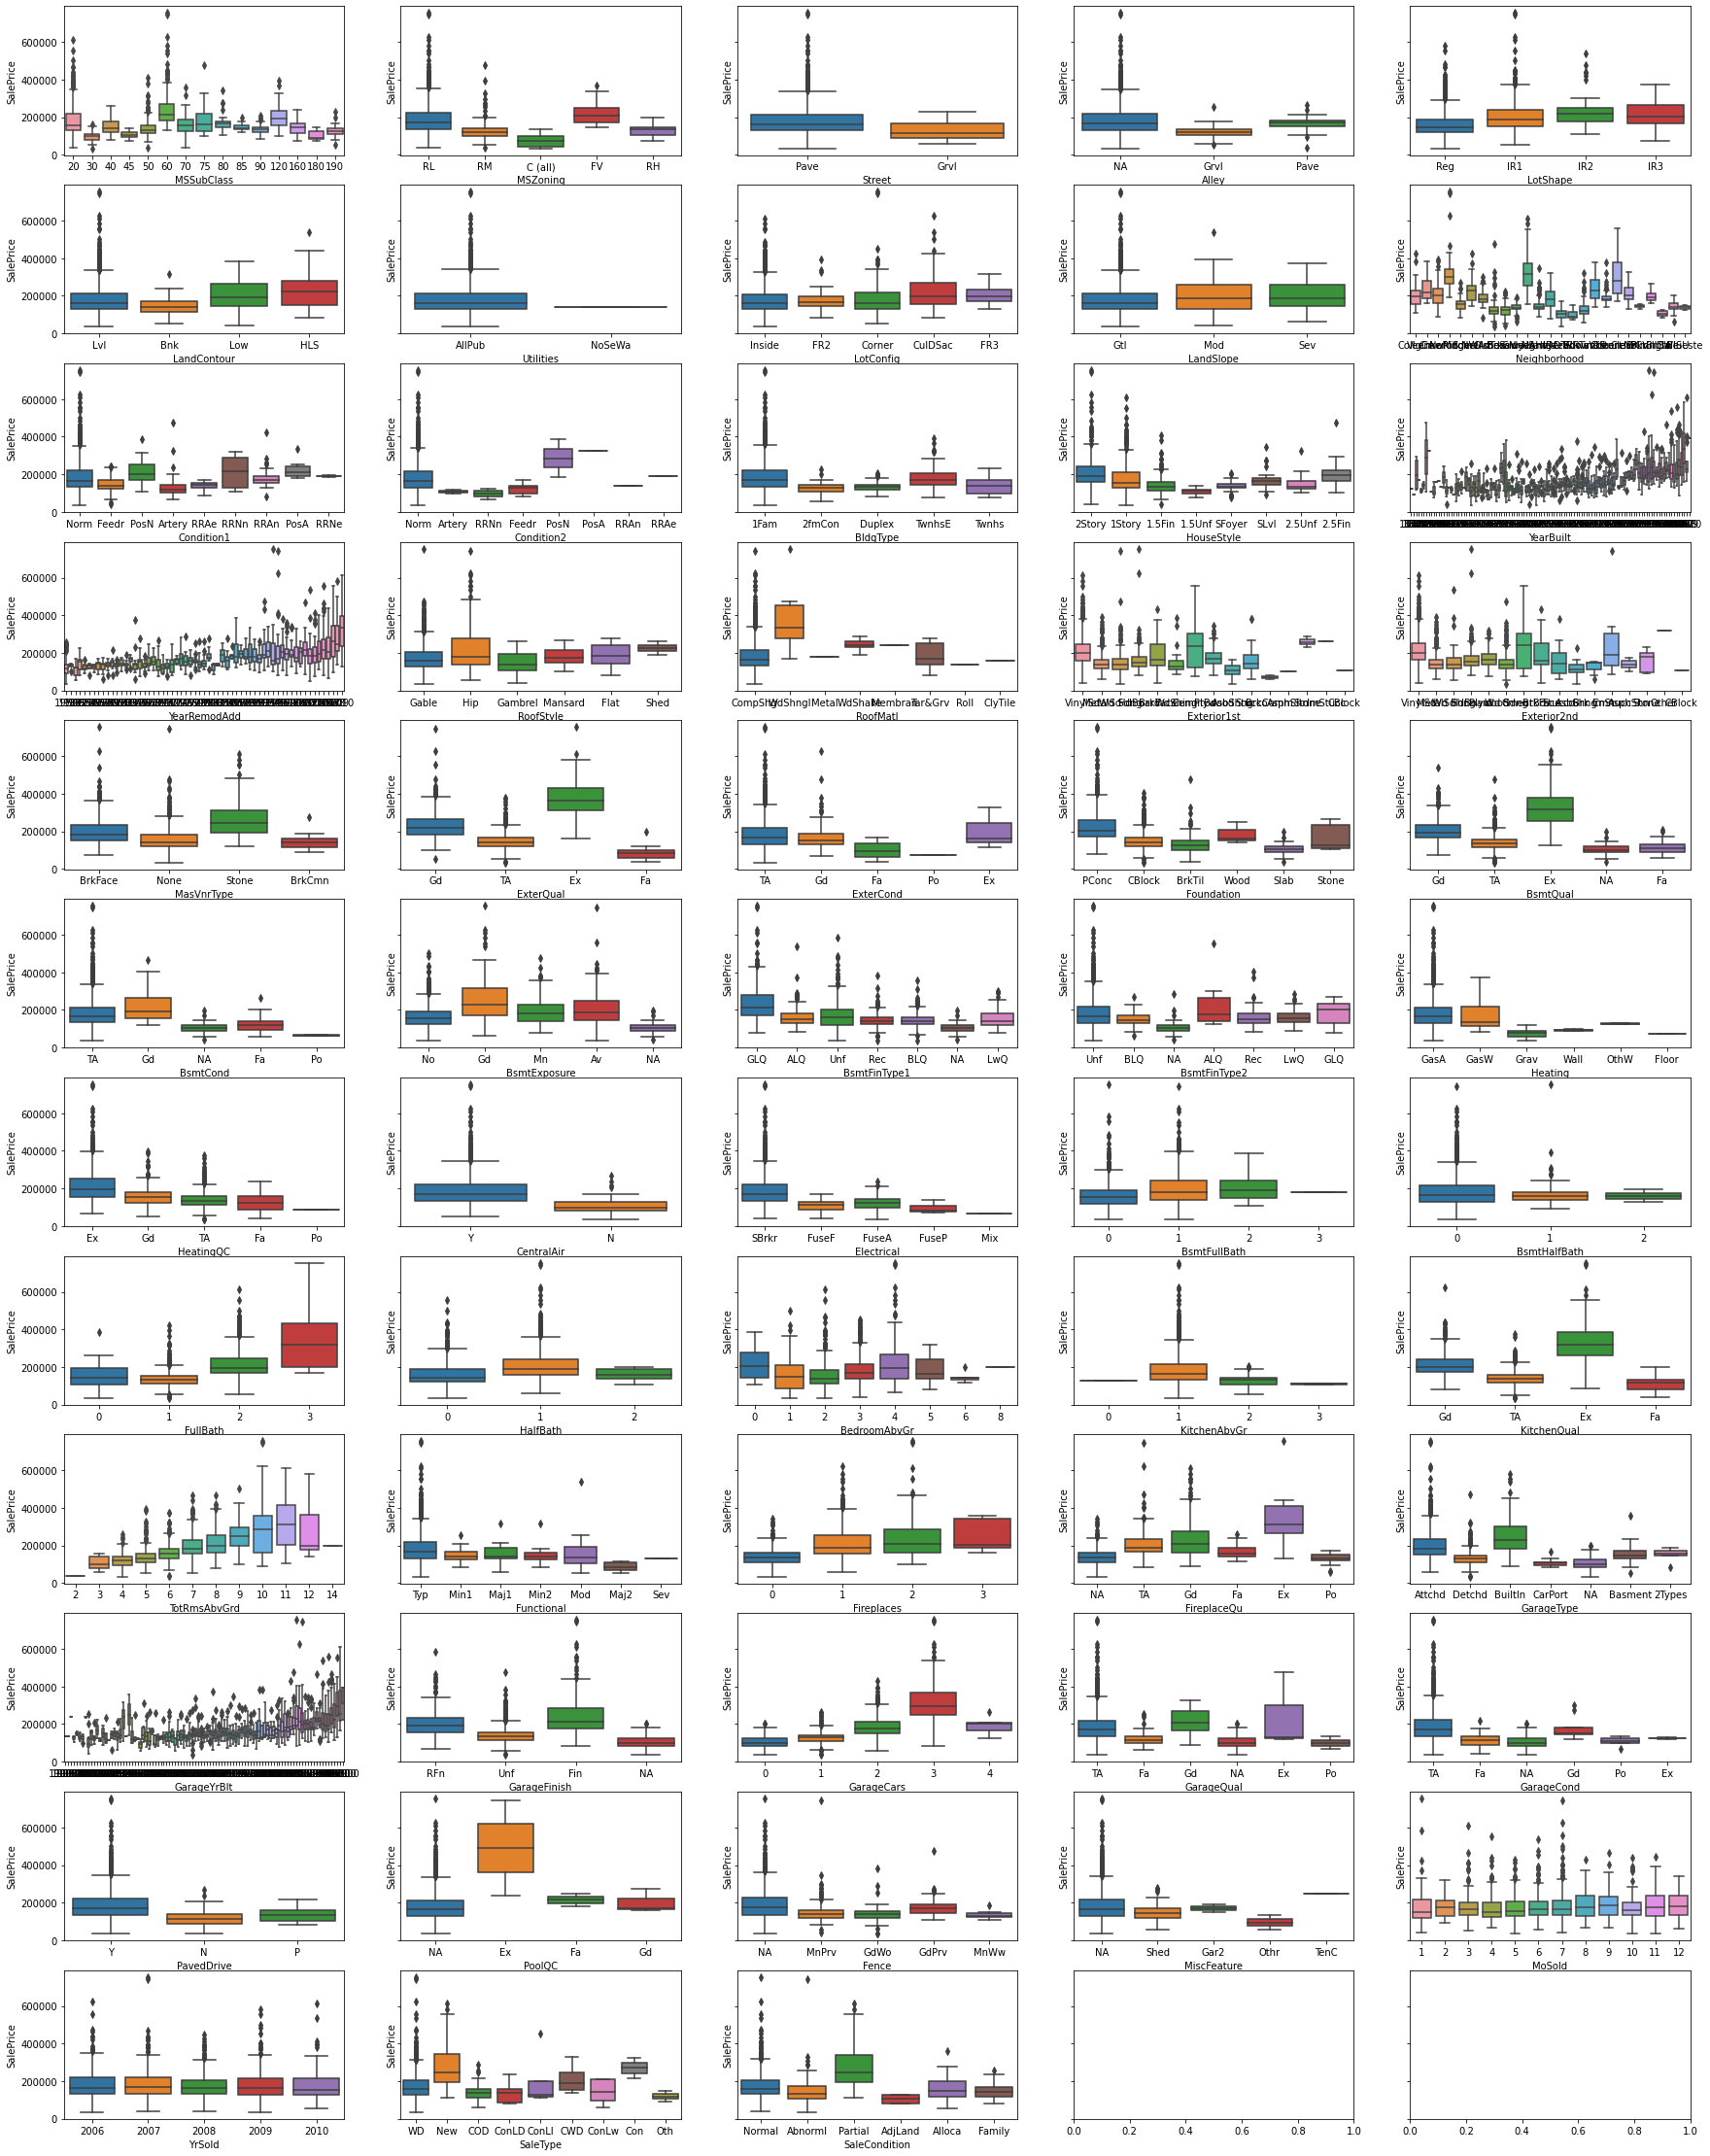

In [12]:
# Creating subplot axes
fig, axes = plt.subplots(12,5,figsize=(30,40), sharey=True)
for name, ax in zip(categorical_vars, axes.flatten()):
    sns.boxplot(y='SalePrice', x= name, data=housing_data, orient='v', ax=ax)
plt.show()


In [ ]:
# TODO : Write more inferences and find more columns to drop

#### Inferences
1. MSSubClass seems to be have some influence on the target variable.
2. Houses with Floating Village Residential & Residential Low Density MSZones tend to have higher Selling Price.
3. Houses with Paved road access tend to have higher SalePrice than Gravel
4. Houses with No Alley access tend to have higher SalePrice
5. Lotshape also have some influence on the target variable but not too much significant.
6. LandContour have some influence on the target variable. Higher SalePrice for Houses on Hillside and Depression
7. Utilities is heavily skewed towards AllPub. Just one datapoint for NoSeWa. Hence it is not an indicator for the SalePrice
8. Higher Influcence Predictors:
    - Neighbourhood
    - Condition1
    - Condition2
    - HouseStyle
    - OverAll quality
    - Overall Cond
    - Roof Material
    - Exterior Covering Materials (both 1 and 2)
    - Exterior Quality
    - Exterior Condition
    - Mass Vnr Type
    - 
9. Comparatively Lower Influence Predictors:
    - LotConfig
    - Landslope
    - Bldng type
    - Roof Style
7. YearBuilt and YearRemodel done doesn't seem to have good influence on the target ==>  Although more data is skewed towards the recent years, it has wide range of salePrice
8. Although recent values of GarageYrBlt have some high SalePrice, it is not a great influence for sale price
9. The variation of SalePrice w.r.t Month Sold or Year Sold is not significant enough



In [ ]:
# Drop columns based on EDA
cols_to_be_dropped = ['Utilities', 'LowQualFinSF','EnclosedPorch','3SsnPorch','ScreenPorch', 'PoolArea', 'MiscVal','MoSold','YrSold']
# cols_to_be_dropped.extend(['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF'])
housing_data.drop(cols_to_be_dropped,axis=1,inplace=True)
print(f"Number of columns after dropping {housing_data.columns.size}")

In [ ]:
# Remove the dropped cols from continuous and categorical list
categorical_vars = [var for var in categorical_vars if var not in cols_to_be_dropped]
continuous_vars =  [var for var in continuous_vars if var not in cols_to_be_dropped]

### Step 4: Preparing the data for Modelling

#### Encoding

In [13]:
# Dummy Encoding for all categorical variables
# Certain Numbers in Categorical Variable are not mapped to string , it is read as string to interpret it better. For eg: OverallCond_10 would be easier to interpret than OverallCond_Very_Excellent
dummy_encoded_values = pd.get_dummies(data=housing_data[categorical_vars].astype(str),drop_first=True)
categorical_vars_encoded = list(dummy_encoded_values.columns)

# Add the new encoded cols to original dataframe and drop the source columns
housing_data = pd.concat([housing_data,dummy_encoded_values],axis=1)
housing_data.drop(categorical_vars,axis=1,inplace=True)

In [14]:
print(f"Number of columns after dummyEncoding {housing_data.columns.size}")

Number of columns after dummyEncoding 580


#### Train test split

In [15]:
df_train, df_test = train_test_split(housing_data,train_size=0.7,random_state=100)
df_train.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=580)

#### Scaling the features using StandardScaler

In [16]:
scaler = StandardScaler()
df_train[continuous_vars] = scaler.fit_transform(df_train[continuous_vars])
df_test[continuous_vars] = scaler.transform(df_test[continuous_vars])
df_train[continuous_vars]

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
318,0.925326,-0.057261,0.648310,-0.532073,0.809137,1.159065,-0.293313,-0.454262,0.621091,0.511410,...,-0.124502,2.121655,0.867501,1.988123,0.195951,1.912645,-0.121922,-0.275126,-0.062302,-0.084263
239,-0.795709,-0.169753,-0.066511,-1.448170,-0.558025,-0.761831,-0.293313,0.172244,-0.712611,-0.931882,...,-0.124502,-0.058599,-1.188045,-0.744598,1.405086,-0.368121,-0.121922,-0.275126,-0.062302,-0.084263
986,-0.478677,-0.502762,-0.066511,2.216221,-0.558025,-0.964030,-0.293313,-0.175567,-1.257424,-0.421449,...,-0.124502,0.219811,-1.023035,2.422143,-0.710899,-0.368121,-0.121922,-0.275126,-0.062302,-0.084263
1416,-0.433386,0.082504,-1.496155,0.384025,-0.558025,-0.964030,-0.293313,0.475464,-0.621082,0.194590,...,-0.124502,1.451965,0.414904,-0.744598,-0.710899,1.437486,-0.121922,-0.275126,-0.062302,-0.084263
390,-0.886290,-0.202365,-0.781333,2.216221,-0.558025,-0.445625,1.996400,-0.746334,-0.438025,-0.522027,...,-0.124502,-0.284338,-0.414858,-0.744598,1.253944,1.405809,-0.121922,-0.275126,-0.062302,-0.084263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,-0.297515,-0.222359,0.648310,-0.532073,-0.558025,0.429856,-0.293313,-1.078538,-0.727866,-1.107893,...,-0.124502,-0.116915,-0.292279,-0.455251,-0.438844,-0.368121,-0.121922,-0.275126,-0.062302,-0.084263
53,-0.071063,3.861107,2.077954,-0.532073,-0.558025,2.929386,-0.293313,-1.185557,1.699820,1.693199,...,-0.124502,0.609209,1.989565,6.143466,0.377322,-0.368121,-0.121922,-0.275126,-0.062302,-0.084263
350,-0.071063,-0.259144,2.077954,-0.532073,1.375227,-0.964030,-0.293313,2.910141,1.758660,1.761090,...,-0.124502,0.660000,0.683633,0.943259,0.105266,-0.368121,-0.121922,-0.275126,-0.062302,-0.084263
79,-0.433386,-0.004850,-0.781333,0.384025,-0.558025,-0.964030,-0.293313,-0.275897,-1.355490,-1.223557,...,-0.124502,-0.542055,-0.150843,-0.149830,-0.710899,1.659227,-0.121922,-0.275126,-0.062302,-0.084263


### Step 5: Model Builiding

#### Utilities

In [17]:
# Calculate Adjusted R2
def adjusted_r2(X,r2_score):
    n = len(X)
    p = len(X.columns)
    return 1-(1-r2_score)*(n-1)/(n-p-1)

In [18]:
# Add Constant
def add_constant(X_train):
    return sm.add_constant(X_train)

In [19]:
## Build Stats Model and return summary
def build_stats_model(X_train,y_train):
    lm = sm.OLS(y_train,add_constant(X_train)).fit() # Fitting the model
    return lm.summary(),lm # Return summary

In [20]:
# Compute VIF
def compute_vif(X_train):
    vif = pd.DataFrame()
    vif['Features'] = X_train.columns
    vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2) # Rounding to 2 decimal values
    vif = vif.sort_values(by = 'VIF', ascending = False)
    return vif

In [21]:
def get_model(model_type,alpha=1.0):
    if model_type == 'Ridge':
        return Ridge(alpha=alpha)
    if model_type == 'Lasso':
        return Lasso(alpha=alpha)

    raise ValueError(f"Invalid Model Type {model_type}") 
    

In [22]:
def build_with_regularization(X_train,y_train,X_test,y_test,model_type,alpha_range,scoring='neg_root_mean_squared_error',folds=5):
    alpha_grid = [{'alpha': alpha_range}]
    grid_search_cv = GridSearchCV(get_model(model_type),param_grid= alpha_grid,scoring=scoring,cv=folds,n_jobs=-1,return_train_score=True)
    grid_search_cv.fit(X_train,y_train)
    best_alpha = grid_search_cv.best_params_['alpha']
    
    model = get_model(model_type,best_alpha)
    model.fit(X_train,y_train)

    y_train_pred = model.predict(X_train)
    train_r2_score = r2_score(y_true=y_train,y_pred=y_train_pred)
    y_test_pred = model.predict(X_test)
    test_r2_score =  r2_score(y_true=y_test,y_pred=y_test_pred)   
    return {'model': model, 'best_alpha': best_alpha, 'best_score': grid_search_cv.best_score_, 'train_r2_score': train_r2_score,'test_r2_score': test_r2_score}

#### Step 5.1: Model Building Without Regularization

In [23]:
# Splitting the training data into X and y
y_train = df_train.pop('SalePrice')
X_train = df_train
y_test = df_test.pop('SalePrice')
X_test = df_test

In [24]:
# Create Linear Regression Model
lm = LinearRegression()
lm.fit(X_train,y_train)

# Running RFE with output number of values as 50
output_var_count = 50
rfe = RFE(lm,n_features_to_select=output_var_count)
rfe = rfe.fit(X_train, y_train)

In [25]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('LotFrontage', False, 431),
 ('LotArea', False, 359),
 ('OverallQual', False, 314),
 ('OverallCond', False, 391),
 ('MasVnrArea', False, 451),
 ('BsmtFinSF1', False, 122),
 ('BsmtFinSF2', False, 159),
 ('BsmtUnfSF', False, 162),
 ('TotalBsmtSF', False, 61),
 ('1stFlrSF', True, 1),
 ('2ndFlrSF', True, 1),
 ('LowQualFinSF', False, 15),
 ('GrLivArea', True, 1),
 ('GarageArea', False, 516),
 ('WoodDeckSF', False, 506),
 ('OpenPorchSF', False, 489),
 ('EnclosedPorch', False, 509),
 ('3SsnPorch', False, 496),
 ('ScreenPorch', False, 501),
 ('PoolArea', False, 438),
 ('MiscVal', False, 405),
 ('MSSubClass_160', False, 363),
 ('MSSubClass_180', False, 335),
 ('MSSubClass_190', False, 24),
 ('MSSubClass_20', False, 373),
 ('MSSubClass_30', False, 388),
 ('MSSubClass_40', False, 269),
 ('MSSubClass_45', False, 303),
 ('MSSubClass_50', False, 370),
 ('MSSubClass_60', False, 301),
 ('MSSubClass_70', False, 371),
 ('MSSubClass_75', False, 35),
 ('MSSubClass_80', False, 375),
 ('MSSubClass_85', Fa

In [26]:
resulting_rfe_cols = X_train.columns[rfe.support_]
resulting_rfe_cols

Index(['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'Condition2_PosN',
       'Condition2_RRAe', 'BldgType_Duplex', 'YearBuilt_1890',
       'YearBuilt_1898', 'YearBuilt_1919', 'YearBuilt_1942', 'YearBuilt_1952',
       'YearBuilt_1969', 'YearBuilt_2001', 'YearRemodAdd_1951',
       'YearRemodAdd_1952', 'YearRemodAdd_1973', 'YearRemodAdd_1979',
       'RoofStyle_Shed', 'RoofMatl_CompShg', 'RoofMatl_Membran',
       'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv',
       'RoofMatl_WdShngl', 'Exterior1st_AsphShn', 'Exterior1st_CBlock',
       'Exterior2nd_CBlock', 'BsmtFinType1_NA', 'BsmtHalfBath_2',
       'BedroomAbvGr_8', 'KitchenAbvGr_1', 'KitchenAbvGr_2', 'KitchenAbvGr_3',
       'TotRmsAbvGrd_14', 'Fireplaces_2', 'GarageYrBlt_1969.0',
       'GarageYrBlt_2001.0', 'GarageFinish_NA', 'GarageCars_1', 'GarageCars_3',
       'GarageQual_Fa', 'GarageQual_NA', 'GarageQual_TA', 'GarageCond_Fa',
       'GarageCond_NA', 'PoolQC_Fa', 'PoolQC_Gd', 'PoolQC_NA', 'SaleType_New',
       'SaleConditi

In [27]:
X_train.columns[~rfe.support_]

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'LowQualFinSF',
       ...
       'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw',
       'SaleType_Oth', 'SaleType_WD', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal'],
      dtype='object', length=529)

In [28]:
# Keeping only the columns from RFE
X_train_rfe = X_train[resulting_rfe_cols]
X_test_rfe = X_test[resulting_rfe_cols]

In [29]:
# Create Linear Regression Model
lm = LinearRegression()
lm.fit(X_train_rfe,y_train)
y_train_pred = lm.predict(X_train_rfe)
y_test_pred = lm.predict(X_test_rfe)
train_r2_score  = r2_score(y_true=y_train,y_pred=y_train_pred)
train_adj_r2_scopre = adjusted_r2(X_train_rfe,train_r2_score)
test_r2_score  = r2_score(y_true=y_test,y_pred=y_test_pred)
test_adj_r2_score = adjusted_r2(X_test_rfe,test_r2_score)
print(f"R2 score of training {train_r2_score}")
print(f"Adj R2 score of training {train_adj_r2_scopre}")
print(f"R2 score of test {test_r2_score}")
print(f"Adj R2 score of test {test_adj_r2_score}")

R2 score of training 0.8150377175745509
Adj R2 score of training 0.8055035793051979
R2 score of test 0.5026804951520796
Adj R2 score of test 0.43859293009435785


##### Inference
- Even though R2 and Adj R2 score for training set seems to be decent , it miserably failed for test data. Let's look at the statistics to understand the significance of the variables

In [30]:
# Get the List of Independent Variables with high p value and/or high vif:
def get_correlated_unreliable_ind_vars(X_train,y_train):
    # Build stats model and get summary
    (results_summary,_) = build_stats_model(X_train,y_train)

    #Read the Metrics from OLS Summary
    results_as_html_0 = results_summary.tables[0].as_html()
    summary_df_0 = pd.read_html(results_as_html_0,index_col=2)[0][[3]]
    summary_df_0.index.name = 'Metric'
    summary_df_0.rename({3:'Value'},axis=1,inplace=True)

    # Read the p value table from OLS Summary
    results_as_html_1 = results_summary.tables[1].as_html()
    summary_df_1 = pd.read_html(results_as_html_1, header=0, index_col=0)[0]
    summary_filtered_df = summary_df_1[summary_df_1['P>|t|'] > 0.05].sort_values('P>|t|',ascending=False)


    #Compute VIF
    vif = compute_vif(X_train)
    vif_filtered_df = vif[vif['VIF'] > 5]

    #Merge both df to combine variables which needs attention
    corr_unr_ind_vars = summary_filtered_df.merge(vif_filtered_df,how='outer',left_index=True,right_on=['Features'])[['Features','P>|t|','VIF']]
    corr_unr_ind_vars.reset_index(drop=True,inplace=True)
    corr_unr_ind_vars.sort_values(by=['P>|t|','VIF'],ascending=False,inplace=True)
    return (corr_unr_ind_vars,summary_df_0,summary_df_1,results_summary,vif)
    

In [31]:
#Recursively remove features based on stats model summary statistics
def recursive_feature_removal(X_train,y_train,iter=1):
    result = []
    (corr_unr_ind_vars,summary_df_0,_,_,_) = get_correlated_unreliable_ind_vars(X_train,y_train)
    if corr_unr_ind_vars.empty:
        top_row = {'Features': None,'VIF': None,'P>|t|': None}
    else:
        top_row = corr_unr_ind_vars.iloc[0]
        
    var_to_drop = top_row['Features']
    vif = top_row['VIF']
    p_value = top_row['P>|t|']
    r2 = summary_df_0.iloc[0]['Value']
    adj_r2 = summary_df_0.iloc[1]['Value']
    result.append({
        'iter': iter,
        'var_to_drop': var_to_drop,
        'vif': vif,
        'p_value': p_value,
        'r2_score': r2,
        'adj_r2_score': adj_r2,
        'X_train': X_train
    })
    if not corr_unr_ind_vars.empty:
        result.extend(recursive_feature_removal(X_train.drop([var_to_drop],axis=1),y_train,iter+1))
    return result


In [32]:
# Get the List of Independent Variables with high p value and/or high vif:
def get_unreliable_ind_vars(X_train,y_train):
    # Build stats model and get summary
    (results_summary,_) = build_stats_model(X_train,y_train)

    #Read the Metrics from OLS Summary
    results_as_html_0 = results_summary.tables[0].as_html()
    summary_df_0 = pd.read_html(results_as_html_0,index_col=2)[0][[3]]
    summary_df_0.index.name = 'Metric'
    summary_df_0.rename({3:'Value'},axis=1,inplace=True)

    # Read the p value table from OLS Summary
    results_as_html_1 = results_summary.tables[1].as_html()
    summary_df_1 = pd.read_html(results_as_html_1, header=0, index_col=0)[0]
    summary_df_1.drop('const',inplace=True)
    summary_filtered_df = summary_df_1[summary_df_1['P>|t|'] > 0.05].sort_values('P>|t|',ascending=False)


    #Merge both df to combine variables which needs attention
    corr_unr_ind_vars = summary_filtered_df
    corr_unr_ind_vars['Features'] = corr_unr_ind_vars.index
    corr_unr_ind_vars.sort_values(by=['P>|t|'],ascending=False,inplace=True)
    return (corr_unr_ind_vars,summary_df_0,summary_df_1,results_summary)
    

In [33]:
#Recursively remove features based on stats model summary statistics
def recursive_feature_removal_only_p(X_train,y_train,iter=1):
    result = []
    (corr_unr_ind_vars,summary_df_0,_,_) = get_unreliable_ind_vars(X_train,y_train)
    if corr_unr_ind_vars.empty:
        top_row = {'Features': None,'P>|t|': None}
    else:
        top_row = corr_unr_ind_vars.iloc[0]
        
    var_to_drop = top_row['Features']
    p_value = top_row['P>|t|']
    r2 = summary_df_0.iloc[0]['Value']
    adj_r2 = summary_df_0.iloc[1]['Value']
    result.append({
        'iter': iter,
        'var_to_drop': var_to_drop,
        'p_value': p_value,
        'r2_score': r2,
        'adj_r2_score': adj_r2,
        'X_train': X_train
    })
    if not corr_unr_ind_vars.empty:
        result.extend(recursive_feature_removal_only_p(X_train.drop([var_to_drop],axis=1),y_train,iter+1))
    return result


In [34]:
rfr_result = recursive_feature_removal_only_p(X_train_rfe,y_train)
pd.DataFrame(rfr_result).head(50)

,iter,var_to_drop,p_value,r2_score,adj_r2_score,X_train
0,1,KitchenAbvGr_3,0.892,0.815,0.807,1stFlrSF 2ndFlrSF GrLivArea Condition...
1,2,YearBuilt_1898,0.892,0.815,0.807,1stFlrSF 2ndFlrSF GrLivArea Condition...
2,3,Exterior1st_AsphShn,0.593,0.815,0.807,1stFlrSF 2ndFlrSF GrLivArea Condition...
3,4,YearBuilt_1942,0.554,0.815,0.808,1stFlrSF 2ndFlrSF GrLivArea Condition...
4,5,KitchenAbvGr_2,0.431,0.815,0.808,1stFlrSF 2ndFlrSF GrLivArea Condition...
5,6,Exterior1st_CBlock,0.345,0.815,0.808,1stFlrSF 2ndFlrSF GrLivArea Condition...
6,7,Exterior2nd_CBlock,0.345,0.815,0.808,1stFlrSF 2ndFlrSF GrLivArea Condition...
7,8,BedroomAbvGr_8,0.268,0.815,0.808,1stFlrSF 2ndFlrSF GrLivArea Condition...
8,9,TotRmsAbvGrd_14,0.268,0.815,0.808,1stFlrSF 2ndFlrSF GrLivArea Condition...
9,10,YearRemodAdd_1973,0.262,0.814,0.808,1stFlrSF 2ndFlrSF GrLivArea Condition...


In [35]:
X_train_final = rfr_result[-1]['X_train']
X_test_final = X_test_rfe[X_train_final.columns]

In [39]:
X_train_final = X_train_rfe
X_test_final = X_test_rfe[X_train_final.columns]

#### Step 5.2: Model Building With Ridge

In [40]:
print(f"Building Model Using Ridge ")
ridge_alphas = list(np.linspace(0,1,100))
result = build_with_regularization(X_train_final,y_train,X_test_final,y_test,'Ridge',ridge_alphas)
print(f"Best Alpha: {result['best_alpha']}")
print(f"Best Score: {result['best_score']}")
print(f"Training R2 Score: {result['train_r2_score']}")
print(f"Test R2 Score: {result['test_r2_score']}")

Building Model Using Ridge 
Best Alpha: 1.0
Best Score: -41947.93391249936
Training R2 Score: 0.7911699786700039
Test R2 Score: 0.6942583637100402


In [37]:
X_train_final.columns.size

30

#### Step 5.3: Model Building With Lasso

In [41]:
print(f"Building Model Using Lasso ")
lasso_alphas = list(np.arange(0,1000,1))
result = build_with_regularization(X_train_final,y_train,X_test_final,y_test,'Lasso',lasso_alphas)
print(f"Best Alpha: {result['best_alpha']}")
print(f"Best Score: {result['best_score']}")
print(f"Training R2 Score: {result['train_r2_score']}")
print(f"Test R2 Score: {result['test_r2_score']}")

Building Model Using Lasso 


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: Use

Best Alpha: 40
Best Score: -41923.94226439994
Training R2 Score: 0.8074753480991339
Test R2 Score: 0.5230402476998204
